In [1]:
%matplotlib inline
import utils#; reload(utils)
from utils import *
from __future__ import division, print_function


import os
import random

import numpy as np
import matplotlib.pyplot as plt

from glob import iglob, glob

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array

from scipy.misc import imresize, toimage
import ujson as json
import cv2

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data/'
%matplotlib inline



Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
DATA_HOME_DIR
# path = DATA_HOME_DIR+"fishnofish/preprocessed/"
path = DATA_HOME_DIR+"fishnofish/"

batch_size=8

In [3]:
anno_classes = ["Fish"]#['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']
target_size = (360,640)


### Loading data

In [4]:


(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

raw_filenames = [f.split('/')[-1] for f in filenames]
#check_output(["ls",path+"train/Fish/"]).decode("utf8").strip().split('\n')
#[f.split('/')[-1] for f in filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]
#check_output(["ls",path+"valid/Fish/"]).decode("utf8").strip().split('\n')
#[f.split('/')[-1] for f in val_filenames]
raw_test_filenames = [f.split('/')[-1] for f in val_filenames]
#get_batches(path+'test', shuffle=False, batch_size=1).filenames

#[f.split('/')[-1] for f in test_filenames]


print (len(raw_filenames), len (raw_val_filenames), len(raw_test_filenames))

Found 3327 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 1000 images belonging to 1 classes.
3327 450 450


# Creating Masks

#### Load bounding boxes

In [17]:
bb_json = {}

j = json.load(open('{}/all_fish_labels.json'.format(DATA_HOME_DIR), 'r'))
print ("Files with multiple bounding boxes: ")
for  i , l in enumerate(j):
    if 'annotations' in l.keys() and len(l['annotations'])>0:
#             bb_json[l['filename'].split('/')[-1]] = sorted(
#                 l['annotations'], key=lambda x: x['height']*x['width'])[-1]
    #use all bounding boxes
        bb_json[l['filename'].split('/')[-1]] = l['annotations']
    if len(l['annotations']) > 1:
        print (l['filename'] , ", index: ", i, ", num bbox: ",len(l['annotations']) )

Files with multiple bounding boxes: 
img_07915.jpg , index:  1 , num bbox:  2
img_07892.jpg , index:  6 , num bbox:  2
img_07890.jpg , index:  7 , num bbox:  2
img_07879.jpg , index:  10 , num bbox:  3
img_07878.jpg , index:  11 , num bbox:  2
img_07876.jpg , index:  13 , num bbox:  2
img_07863.jpg , index:  18 , num bbox:  5
img_07858.jpg , index:  20 , num bbox:  3
img_07814.jpg , index:  26 , num bbox:  2
img_07801.jpg , index:  31 , num bbox:  2
img_07772.jpg , index:  37 , num bbox:  2
img_07767.jpg , index:  40 , num bbox:  2
img_07766.jpg , index:  41 , num bbox:  2
img_07749.jpg , index:  44 , num bbox:  2
img_07740.jpg , index:  47 , num bbox:  3
img_07739.jpg , index:  48 , num bbox:  2
img_07726.jpg , index:  53 , num bbox:  2
img_07720.jpg , index:  54 , num bbox:  4
img_07705.jpg , index:  57 , num bbox:  2
img_07686.jpg , index:  62 , num bbox:  4
img_07672.jpg , index:  65 , num bbox:  2
img_07657.jpg , index:  72 , num bbox:  3
img_07652.jpg , index:  73 , num bbox:  2


In [19]:
len(bb_json)

3297

In [20]:
bb_json['img_07890.jpg']
# 
#img_01912.jpg

[{u'class': u'rect',
  u'height': 191.0,
  u'width': 85.0,
  u'x': 656.0,
  u'y': 430.0},
 {u'class': u'rect',
  u'height': 93.0,
  u'width': 96.0,
  u'x': 838.0,
  u'y': 310.0}]

In [21]:
#For any images that have no annotations (but are supposed to), we'll create an empty bounding box.

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}
training_null_count = 0 
valid_null_count = 0 

for f in raw_filenames:
    if not f in bb_json.keys():
        print (f, " not found (training)")
        bb_json[f] = [empty_bbox]
        training_null_count += 1 
        
for f in raw_val_filenames:
    if not f in bb_json.keys(): 
        print (f, " not found (validation)")
        bb_json[f] = [empty_bbox]
        valid_null_count += 1
        
         

img_00576.jpg  not found (training)
img_07008.jpg  not found (training)
img_04798.jpg  not found (training)
img_02785.jpg  not found (training)
img_05444.jpg  not found (training)
img_01958.jpg  not found (training)
img_06460.jpg  not found (training)
img_06082.jpg  not found (training)
img_06773.jpg  not found (training)
img_04558.jpg  not found (training)
img_02292.jpg  not found (training)
img_03183.jpg  not found (training)
img_00568.jpg  not found (training)
img_06675.jpg  not found (training)
img_07100.jpg  not found (training)
img_01579.jpg  not found (training)
img_00616.jpg  not found (training)
img_04457.jpg  not found (training)
img_07584.jpg  not found (training)
img_05993.jpg  not found (training)
img_04395.jpg  not found (training)
img_04493.jpg  not found (training)
img_03765.jpg  not found (training)
img_02534.jpg  not found (training)
img_02716.jpg  not found (training)
img_02366.jpg  not found (training)
img_03332.jpg  not found (training)
img_05474.jpg  not found (tr

In [22]:
bb_json['img_00022.jpg']


[{'height': 0.0, 'width': 0.0, 'x': 0.0, 'y': 0.0}]

In [23]:
print (training_null_count, valid_null_count)

420 60


In [24]:
bb_params = ['height', 'width', 'x', 'y']

#bb: an array of boxes
def convert_bb(boxes, size, resized_width=640.,resized_height=360. ):
    
    output = []
#     print (boxes)

    for bb in boxes:
    
        bb = [bb[p] for p in bb_params]


            # conversion factors
        conv_x = (resized_width / size[0])
        conv_y = (resized_height / size[1])


        bb[0] = bb[0]*conv_y#+10
        bb[1] = bb[1]*conv_x#+10

    #     bb[2] = max((bb[2]*conv_x - 10), 0)
    #     bb[3] = max((bb[3]*conv_y - 10), 0)
        bb[2] = max((bb[2]*conv_x), 0)
        bb[3] = max((bb[3]*conv_y), 0)

#         print (bb)
        
        output.append(bb)


    return output
    

In [25]:
filenames[0]

'Fish/img_07418.jpg'

In [28]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]


In [29]:
len(sizes), len(raw_val_sizes)

(3327, 450)

In [30]:
trn_bbox = [convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)]
val_bbox = [convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, raw_val_sizes)]

In [31]:
print (len(trn_bbox), len(val_bbox))

3327 450


In [32]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=1)

def show_bb(i):
    boxes  = val_bbox[i]
    plot(val[i])
    for bb in boxes:
        plt.gca().add_patch(create_rect(bb))

In [24]:
# show_bb(103)
#286 #18

## Create masks 


In [33]:
# bb_params = ['height', 'width', 'x', 'y']

def get_coordinates(bbox):
    height = bbox[0]
    width = bbox[1]
    
    #bottom left
    x0 = bbox[2] 
    y0 =  bbox[3]

    return [[x0,y0],[x0+width,y0],[x0+width,y0+height],[x0,y0+height]]


let's do a quick test first

In [114]:
polygon_test = []
img_id = 209
for box in val_bbox[img_id]:
    polygon_test.append(np.array(get_coordinates(box),np.int32))
# polygon_test

mask = np.zeros((360, 640), dtype="int32")
mask = cv2.fillPoly(mask, np.int32(polygon_test),255)


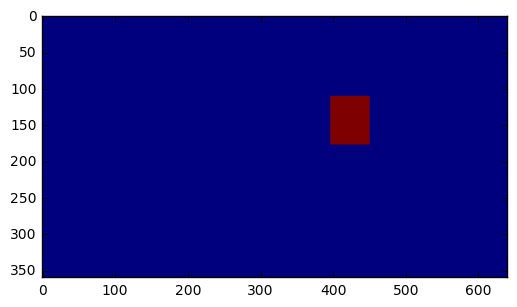

In [115]:
plt.imshow(mask)

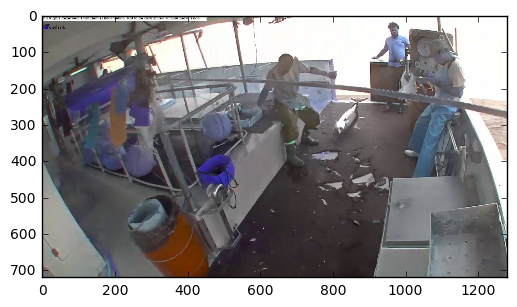

In [116]:

tmp_val1  = cv2.imread(path+'valid/Fish/'+raw_val_filenames[img_id],1)
plt.imshow(tmp_val1  )

Sample looks good, let's create masks for all files and store them

### Create masks for all training and validation data


In [123]:





# storing mask files 
# for f,s in zip(raw_filenames, sizes):
#     boxes = convert_bb(bb_json[f], s)
    
    
#     mask_patches = []
#     for box in boxes:
#         mask_patches.append(np.array(get_coordinates(box),np.int32))    
    
    
#     mask = np.zeros(target_size, dtype="int32")
#     mask = cv2.fillPoly(mask, np.int32(mask_patches),255)
#     cv2.imwrite(path+"mask/train/Fish/"+f,mask) 
    
# # create mask for validation data

# for f,s in zip(raw_val_filenames, sizes):
#     boxes = convert_bb(bb_json[f], s)
    
    
#     mask_patches = []
#     for box in boxes:
#         mask_patches.append(np.array(get_coordinates(box),np.int32))    
    
    
#     mask = np.zeros(target_size, dtype="int32")
#     mask = cv2.fillPoly(mask, np.int32(mask_patches),255)

#     cv2.imwrite(path+"mask/valid/Fish/"+f,mask)     
    

add masks for Nof Class

In [125]:
from subprocess import check_output

# zeromask = np.zeros(target_size, dtype="int32")

# #training NoF
# file_names = check_output(["ls",path+"train/NoF/"]).decode("utf8").strip().split('\n')
# for f in file_names:
#     cv2.imwrite(path+"mask/train/NoF/"+f,zeromask) 
    
# #validation NoF
# file_names = check_output(["ls",path+"valid/NoF/"]).decode("utf8").strip().split('\n')
# for f in file_names:
#     cv2.imwrite(path+"mask/valid/NoF/"+f,zeromask)     

#### Verify results

In [127]:
tmp_mask= cv2.imread(path+"mask/train/Fish/img_07915.jpg")
tmp_trn = cv2.imread(path+"train/Fish/img_07915.jpg")

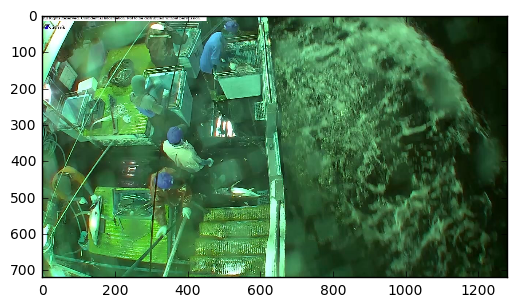

In [128]:
plt.imshow(tmp_trn)

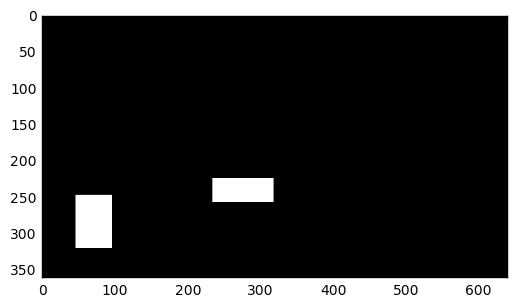

In [129]:
plt.imshow(tmp_mask)

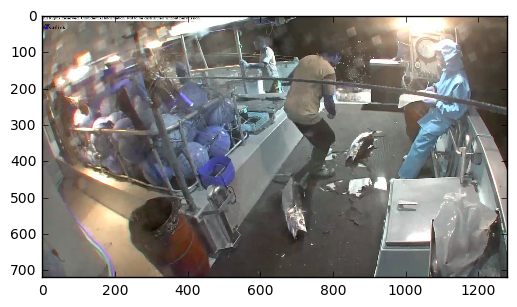

In [130]:
tmp_mask= cv2.imread(path+"mask/valid/Fish/img_07739.jpg")
tmp_valid = cv2.imread(path+"valid/Fish/img_07739.jpg")

plt.imshow(tmp_valid)

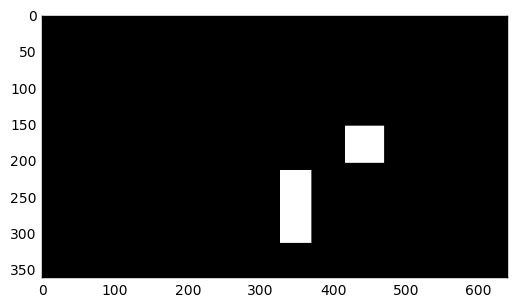

In [131]:
plt.imshow(tmp_mask)

#### Generate in-memory masks

In [34]:
trn_bbox = [convert_bb(bb_json[f], s,resized_width=40,resized_height=22) for f,s in zip(raw_filenames, sizes)]
val_bbox = [convert_bb(bb_json[f], s,resized_width=40,resized_height=22) for f,s in zip(raw_val_filenames, raw_val_sizes)]



In [35]:
trn_targets = []
val_targets = [] 


#training bboxes
for i,b in enumerate(trn_bbox):
    
    #get individual fish bboxes
    mask_patches = []
    for box in trn_bbox[i]:
        mask_patches.append(np.array(get_coordinates(box),np.int32))    
    
    
    mask = np.zeros((22, 40), dtype="int32")
    
    mask = cv2.fillPoly(mask, np.int32(mask_patches),255)
    trn_targets.append(mask)
    
    
#validation bboxes
for i,b in enumerate(val_bbox):
    
    mask_patches = []
    for box in val_bbox[i]:
        mask_patches.append(np.array(get_coordinates(box),np.int32))
        
        
    mask = np.zeros((22, 40), dtype="int32")
    mask = cv2.fillPoly(mask, np.int32(mask_patches),255)
    val_targets.append(mask)    

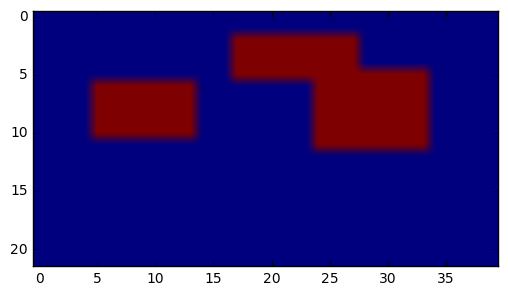

In [36]:
plt.imshow(val_targets[103])

## Model Training

In [10]:
#helper class

class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list
#         if self.multi:
#             self.N = sum([it[0].N for it in self.iters])
#         else:
        self.N = sum([it.N for it in self.iters])

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):
#         if self.multi:
#             nexts = [[next(it) for it in o] for o in self.iters]
#             n0s = np.concatenate([n[0] for n in o])
#             n1s = np.concatenate([n[1] for n in o])
#             return (n0, n1)
#         else:
        nexts = [next(it) for it in self.iters]
#         n0 = np.concatenate([n[0] for n in nexts])
#         n1 = np.concatenate([n[1] for n in nexts])
        return (np.array(nexts[0]), np.array(nexts[1]))



### In-memory flow

In [5]:
target_size = (360, 640)#(180, 320)#
small_target_size = (22, 40) #(11,20) 
batch_size = 16 

# trn = get_data(path+'train', (180, 320))
# val = get_data(path+'valid', (180, 320))

# trn = load_array(path+"results/trn_640.dat")
val = load_array(path+"results/val_640.dat")

In [6]:
# trn = load_array(path+"results/trn_640.dat")
# mask_trn = get_data(path+'mask/train', small_target_size)
# mask_val = get_data(path+'mask/valid',target_size )#(180, 320)


Found 450 images belonging to 2 classes.


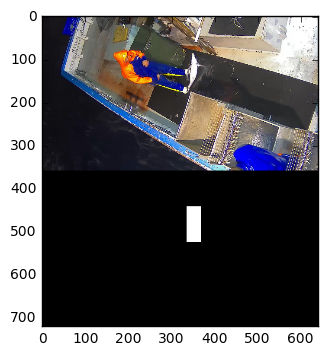

In [7]:
numimage= 271 
plot(np.hstack((val[numimage],mask_val[numimage])))

In [76]:
from keras.preprocessing.image import ImageDataGenerator
# we create two instances with the same arguments
# featurewise_center=True,
#                      featurewise_std_normalization=True,
data_gen_args = dict(
                     rotation_range=10,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=False, fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods

seed = 2019




In [77]:
# Only required if featurewise_center or featurewise_std_normalization or zca_whitening.
# image_datagen.fit(trn, augment=True, seed=seed)
# mask_datagen.fit(mask_trn, augment=True, seed=seed)


In [78]:
# len(check_output(["ls",path+"mask/train/NoF/"]).decode("utf8").strip().split('\n'))

In [154]:
from itertools import izip
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

image_generator_trn = image_datagen.flow_from_directory(
    path+'train',
    class_mode=None,
    target_size = target_size,
    batch_size = batch_size,
    shuffle= False,
    seed=seed)


mask_generator_trn = mask_datagen.flow_from_directory(
    path+'mask/train',
    class_mode=None,
    target_size = small_target_size,
    batch_size = batch_size,
    shuffle= False,
    seed=seed)

# train_generator = izip(image_generator_trn, mask_generator_trn)

mi = MixIterator([image_generator_trn, mask_generator_trn])


Found 3327 images belonging to 2 classes.
Found 3327 images belonging to 2 classes.


In [155]:
minext = mi.next()

In [156]:
train_img = minext[0]
train_mask =  minext[1][:,0,:,:] #only interested in one channel (num items, channels, height, width)

In [157]:
#generate images and corresponding masks for pre-computation 

for i in range (int(3327/batch_size)): 
    minext = mi.next()
    train_img = np.concatenate((train_img,minext[0]))
    train_mask = np.concatenate((train_mask,minext[1][:,0,:,:]))

    

In [159]:
print (train_img.shape, train_mask.shape)

(3327, 3, 360, 640) (3327, 22, 40)


In [160]:
save_array(path+"results/augmented_train_images_640.dat",train_img)
save_array(path+"results/augmented_train_masks.dat",train_mask)

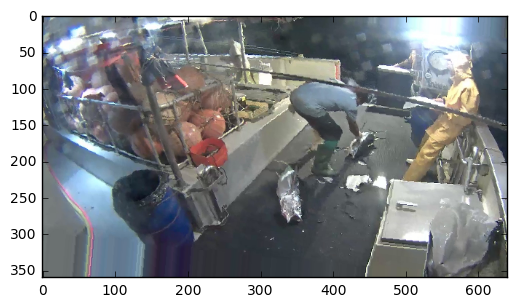

In [172]:
#verify results 

# nx  = mi.next()
img_num = 148
plot(train_img[img_num])

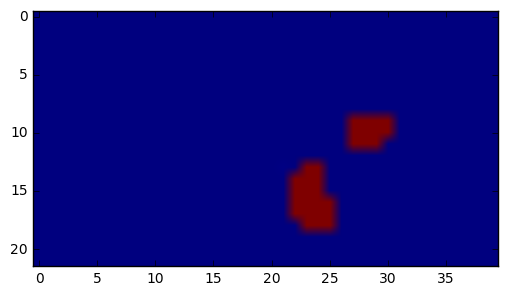

In [173]:
plt.imshow(train_mask[img_num])

In [174]:
# load original photos and masks 
trn = load_array(path+"results/trn_640.dat")
# mask_trn = get_data(path+'mask/train', small_target_size)
# save_array(path+"results/train_mask_22x40.dat",mask_trn)

Found 3327 images belonging to 2 classes.


In [178]:
mask_trn = mask_trn[:,0,:,:]

In [180]:
trn_photos_aug_n_orig = np.concatenate((train_img,trn)) 
trn_masks_aug_n_orig = np.concatenate((train_mask,mask_trn))  # bad naming .. 

MemoryError: 

In [92]:
from keras.preprocessing.image import ImageDataGenerator
from itertools import izip


########################## Validation generators #############


image_generator_valid = ImageDataGenerator().flow_from_directory(
    path+'valid',
    class_mode=None,
    target_size = target_size,
    batch_size = batch_size,
    shuffle= False,
    seed=seed)
    
mask_generator_valid = ImageDataGenerator().flow_from_directory(
    path+'mask/valid',
    class_mode=None,
    target_size = small_target_size,
    batch_size = batch_size,
    shuffle= False,
    seed=seed)



valid_generator = izip(image_generator_valid, mask_generator_valid)
# valid_generator = ImageDataGenerator().flow(val,mask_val,batch_size= batch_size)


Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


#### Precompute vgg features 

In [81]:
vgg_common = Vgg16BN(size=target_size).model

# print (vgg_dense.input_shape, vgg_dense.output_shape)

In [86]:
vgg_common.layers[-1]

going to make the top 2 conv layers trainable, so we remove them from pre-compute part:

vgg_common.summary():
....

convolution2d_12 (Convolution2D) (None, 512, 22, 40)   2359808     zeropadding2d_12[0][0]           
____________________________________________________________________________________________________
zeropadding2d_13 (ZeroPadding2D) (None, 512, 24, 42)   0           convolution2d_12[0][0]           
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 512, 22, 40)   2359808     zeropadding2d_13[0][0]           
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 512, 11, 20)   0           convolution2d_13[0][0]  

In [87]:
for i in range(5):
    vgg_common.pop()

In [89]:
# vgg_common.summary()

In [ ]:
da_conv_featx2 = vgg_common.predict_generator(aug_trn_batches, aug_trn_batches.nb_sample)


### add top layers

In [96]:
nf=128; p=0.6

# from keras.layers.pooling import GlobalMaxPooling2D
def get_fcn_layers():
    return [
        
        #default vgg layers
        ZeroPadding2D((1, 1), input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(512,3,3, activation='relu'),
        ZeroPadding2D((1, 1)),
        Convolution2D(512,3,3, activation='relu'),

        #new layers
#         BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),

        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Dropout(p/3),

        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Dropout(p/2),

        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Dropout(p),
        
        Convolution2D(3,3,3, border_mode='same')
#         GlobalAveragePooling2D(),
#         Activation('softmax')
    ]

In [97]:
conv_layers = vgg_common.layers
 

In [102]:
model = Sequential(get_fcn_layers())

print (model.input_shape, model.output_shape)
print (vgg_common.input_shape, vgg_common.output_shape)


(None, 512, 22, 40) (None, 3, 22, 40)
(None, 3, 360, 640) (None, 512, 22, 40)


In [103]:
# model.summary()

In [118]:
model.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [119]:
model.fit_generator(mi, 3327,
                    nb_epoch=5,
                    validation_data = valid_generator,
                    nb_val_samples=450)


Epoch 1/5
3327/3327 [==============================] - 502s - loss: 2347.4795 - acc: 0.0250 - val_loss: 1944.4413 - val_acc: 0.0303
Epoch 2/5
3327/3327 [==============================] - 503s - loss: 2220.6852 - acc: 0.0147 - val_loss: 2171.0905 - val_acc: 0.0127
Epoch 3/5
3327/3327 [==============================] - 503s - loss: 2154.3996 - acc: 0.0139 - val_loss: 2217.8320 - val_acc: 0.0095
Epoch 4/5
2736/3327 [=======================>......] - ETA: 79s - loss: 2387.1336 - acc: 0.0158

KeyboardInterrupt: 

In [42]:
trn_targets = np.array(trn_targets)
val_targets = np.array(val_targets)

trn_reshaped = trn_targets.reshape(trn_targets.shape[0],1,trn_targets.shape[1],trn_targets.shape[2])
val_reshaped = val_targets.reshape(val_targets.shape[0],1,val_targets.shape[1],val_targets.shape[2])

In [ ]:
# model.fit_generator(
#     zip(image_generator_trn, mask_generator_trn),
#     steps_per_epoch=(3327/batch_size),
#     validation_data= (valid, val_reshaped),
#     validation_steps=450,
#     epochs=3)

In [45]:
# model.save_weights(path+"models/bboxdetector_lr3_good_visual_accuracy.hd5")
model.save_weights(DATA_HOME_DIR+"fishnofish/models/bboxdetector_lr3_multibbox_aug.hd5")

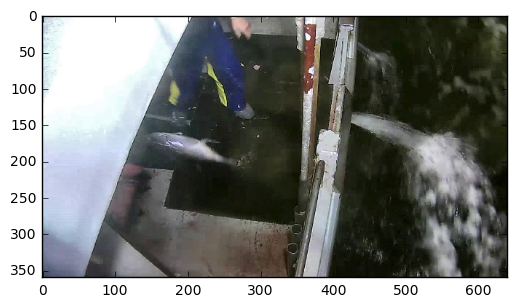

In [47]:
l = model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-1].output)

def get_cm(inp, label):
    conv = conv_fn([inp,0])[0, label] #conf_fn shape (1, 1, 22, 40)
    return scipy.misc.imresize(conv, target_size, interp='nearest')

num_image = 120

plt.imshow(to_plot(val[num_image]))

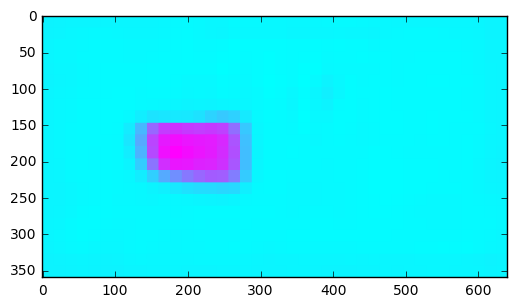

In [48]:
inp = np.expand_dims(conv_val_feat[num_image], 0)
np.round(model.predict(inp)[0],2)


cm = get_cm(inp, 0)
plt.imshow(cm, cmap="cool")

#### Verifing performance on test data

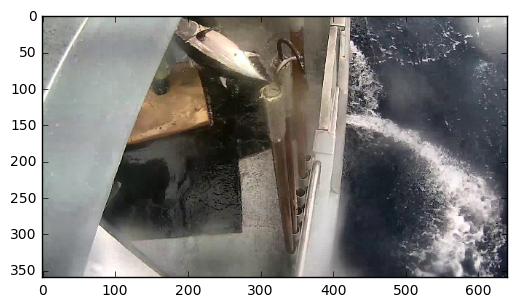

In [118]:
#bad: 489 486 513 580  629
#fantastic:  200 48
#easy: 413 412 195 918

#fixed 999
#got worse 522 200
num_image = 739
plt.imshow(to_plot(test[num_image]))


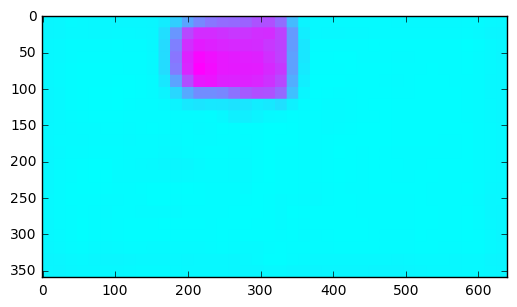

In [119]:
inp = np.expand_dims(conv_test_feat[num_image], 0)
np.round(model.predict(inp)[0],2)


cm = get_cm(inp, 0)
plt.imshow(cm, cmap="cool")

### Crop hotzones

In [58]:
ret, thresh = cv2.threshold(cm, 200, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

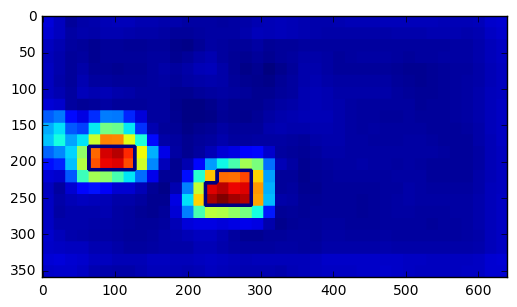

In [59]:
plt.imshow(cv2.drawContours(cm, contours, -1, (0,255,0), 3))


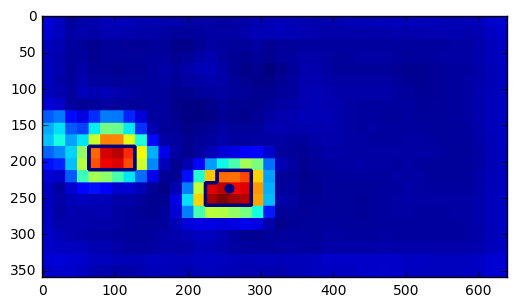

In [60]:
# find a better function than surface. total sum of pixels inside?
def find_biggest_contour(contours):
    
    # nofish? 
    
    
#     if len(contours) == 1 :
#         return 0
    
    #if more than one contour, find the biggest contour surface
    biggest_contour_index = -1 
    biggest_contour_surface = 0

    i = 0
    for c in contours:
        # compute the center of the contour
        area = cv2.contourArea(c)
        if area > biggest_contour_surface:
            biggest_contour_surface = area
            biggest_contour_index = i
        i += 1
        
    return biggest_contour_index        
        
#find center of the biggest contour

i = find_biggest_contour(contours)
M = cv2.moments(contours[i])
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
    

# draw the contour and center of the shape on the image
cv2.circle(cm, (cX, cY), 7, (0, 0, 0), -1)
plt.imshow(cv2.drawContours(cm, [contours[i]], -1, (0, 255, 0), 2))


In [315]:
print (cX,cY)

351 262


In [316]:
crop_width = 300.0

x0  = cX - crop_width/2
y0 = cY - crop_width/2

#what if it's in the corner